**Framing the problem**

Defination:
  
  Customer Churn - Percentage of Users who have discontinued their subscription with the company. It is a critical metric for business and can have significant impact on the profit margin, since it is much more expensive to acquire new customers then to retain existing customers.

Objective:

  In this problem we'll explore the Kaggle telecom user dataset and try to accomplish the following-
  1. Build a Classification model based on past users data to predict user churn.
  2. What services are most popular for the company.


**Gathering Data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,MinMaxScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


%matplotlib inline

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhinavraj9999","key":"1d46748cfd67e62e6e0225af5c6bc77c"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download blastchar/telco-customer-churn

!unzip telco-customer-churn.zip
!ls

  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 86.0MB/s]
Archive:  telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  
kaggle.json  telco-customer-churn.zip
sample_data  WA_Fn-UseC_-Telco-Customer-Churn.csv


In [ ]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('display.max_columns',None)

**Data PreProcessing**

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
#Convert TotalCharges to float type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')
df['TotalCharges'] = df['TotalCharges'].astype(float)
#Convert SeniorCitizen to object
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)
#Drop customerID column
df.drop('customerID',axis=1,inplace=True)

In [ ]:
#Check and fix missing Values
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.insert(len(df.columns)-2,'tenure',df.pop('tenure'))

In [ ]:
for col in df.columns:
  if df[col].nunique() <=4:
    print(f'{col}:{df[col].unique()}')
  else:
    print(f'{col}:{len(df[col].unique())}')

gender:['Female' 'Male']
SeniorCitizen:[0 1]
Partner:['Yes' 'No']
Dependents:['No' 'Yes']
PhoneService:['No' 'Yes']
MultipleLines:['No phone service' 'No' 'Yes']
InternetService:['DSL' 'Fiber optic' 'No']
OnlineSecurity:['No' 'Yes' 'No internet service']
OnlineBackup:['Yes' 'No' 'No internet service']
DeviceProtection:['No' 'Yes' 'No internet service']
TechSupport:['No' 'Yes' 'No internet service']
StreamingTV:['No' 'Yes' 'No internet service']
StreamingMovies:['No' 'Yes' 'No internet service']
Contract:['Month-to-month' 'One year' 'Two year']
PaperlessBilling:['Yes' 'No']
PaymentMethod:['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges:1584
TotalCharges:6530
tenure:72
Churn:['No' 'Yes']


**EDA**

In [ ]:
#EDA1 - Univariate
df.describe()

,MonthlyCharges,TotalCharges,tenure
count,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,32.421786
std,30.085974,2266.771362,24.545260
min,18.250000,18.800000,1.000000
25%,35.587500,401.450000,9.000000
50%,70.350000,1397.475000,29.000000
75%,89.862500,3794.737500,55.000000
max,118.750000,8684.800000,72.000000


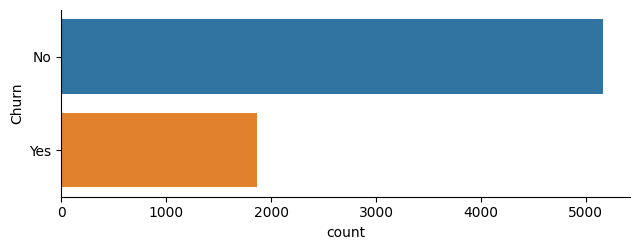

In [ ]:
ax = sns.catplot(y="Churn", kind="count", data=df, height=2.6, aspect=2.5, orient='h')

From the above plot we can conclude:

*   Since most of the clients are retained by the company we have a slightly inbalanced target value

<Axes: xlabel='TotalCharges', ylabel='Count'>

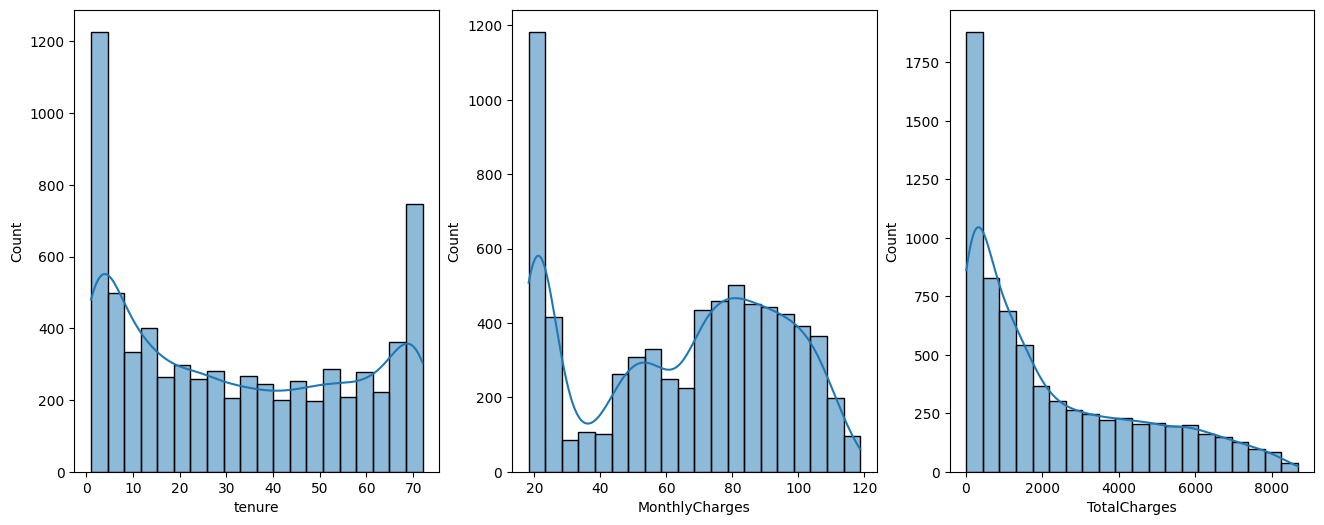

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.histplot(df["tenure"], kde=True, bins=20, ax=axes[0])
sns.histplot(df["MonthlyCharges"], kde=True, bins=20, ax=axes[1])
sns.histplot(df["TotalCharges"], kde=True, bins=20, ax=axes[2])

From the above plot we can conclude:


*   tenure and MonthlyCharges columns have almost bimodal distribution
*   TotalCharges has a strong right skewed distribution.



<Axes: >

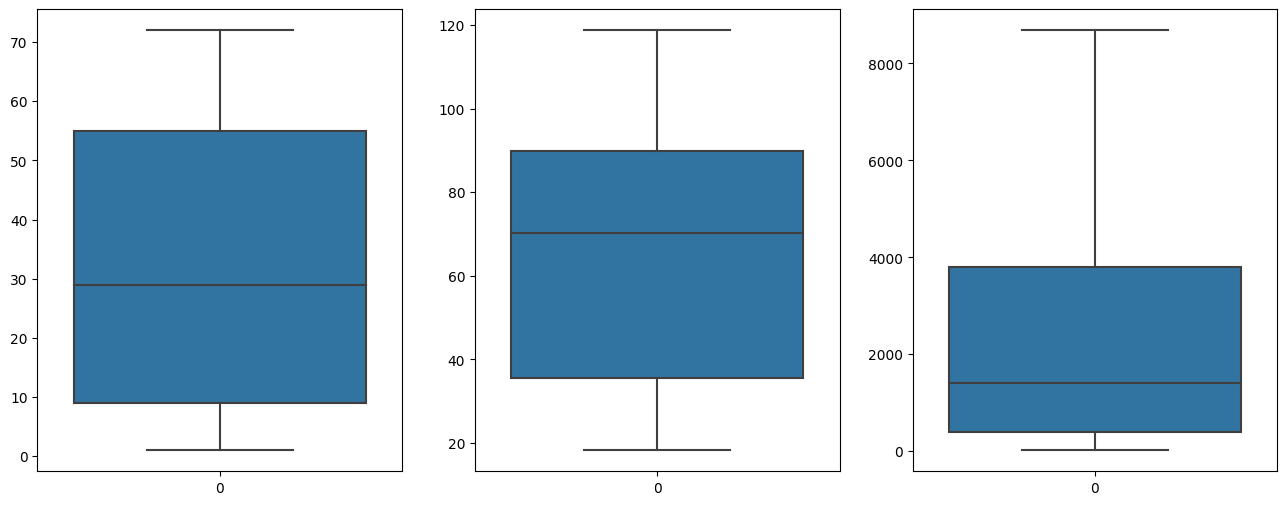

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.boxplot(df["tenure"], ax=axes[0])
sns.boxplot(df["MonthlyCharges"], ax=axes[1])
sns.boxplot(df["TotalCharges"], ax=axes[2])

From the above plot we can conclude that none of the numerical features for the dataset have any outliers

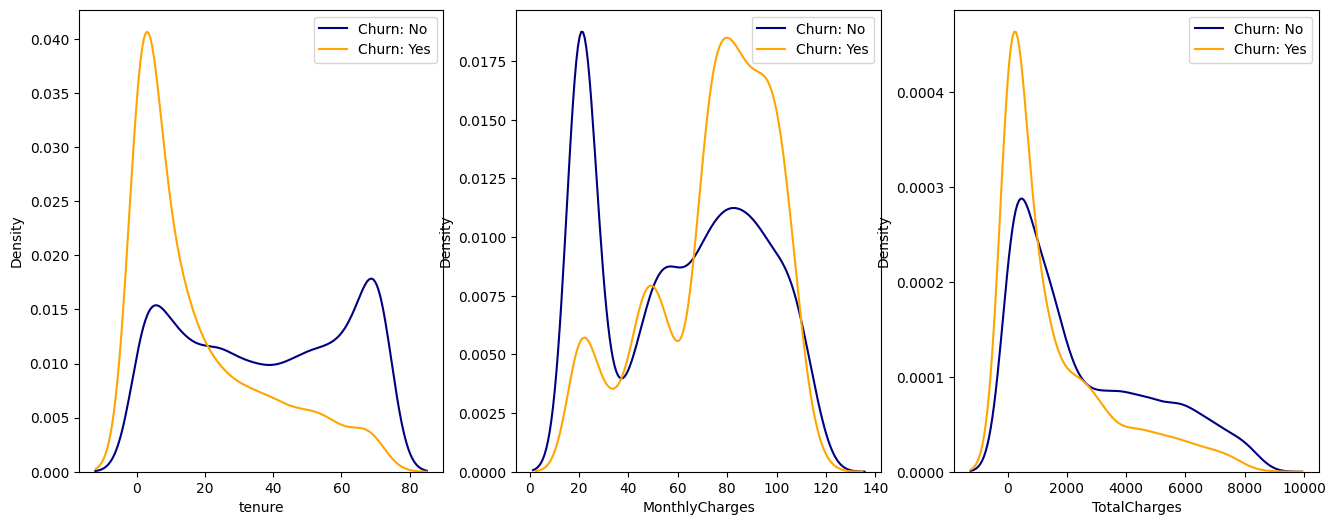

In [ ]:
#EDA2 - MultiVariate
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.kdeplot(df[df['Churn'] == 'No']['tenure'], ax=axes[0],color= 'navy', label= 'Churn: No')
sns.kdeplot(df[df['Churn'] == 'Yes']["tenure"], ax=axes[0],color= 'orange', label= 'Churn: Yes')
sns.kdeplot(df[df['Churn'] == 'No']['MonthlyCharges'], ax=axes[1],color= 'navy', label= 'Churn: No')
sns.kdeplot(df[df['Churn'] == 'Yes']['MonthlyCharges'], ax=axes[1],color= 'orange', label= 'Churn: Yes')
sns.kdeplot(df[df['Churn'] == 'No']['TotalCharges'], ax=axes[2],color= 'navy', label= 'Churn: No')
sns.kdeplot(df[df['Churn'] == 'Yes']['TotalCharges'], ax=axes[2],color= 'orange', label= 'Churn: Yes')

axes[0].legend()
axes[1].legend()
axes[2].legend()


From the above plot we can conclude:


*   Clients with shorter tenure are more at risk to churn
*   Clients with higher monthly charges are more at risk to churn
*   TotalCharges is postively skewed since most people would have TotalCharge paid close to the mean and a very few would have high bills





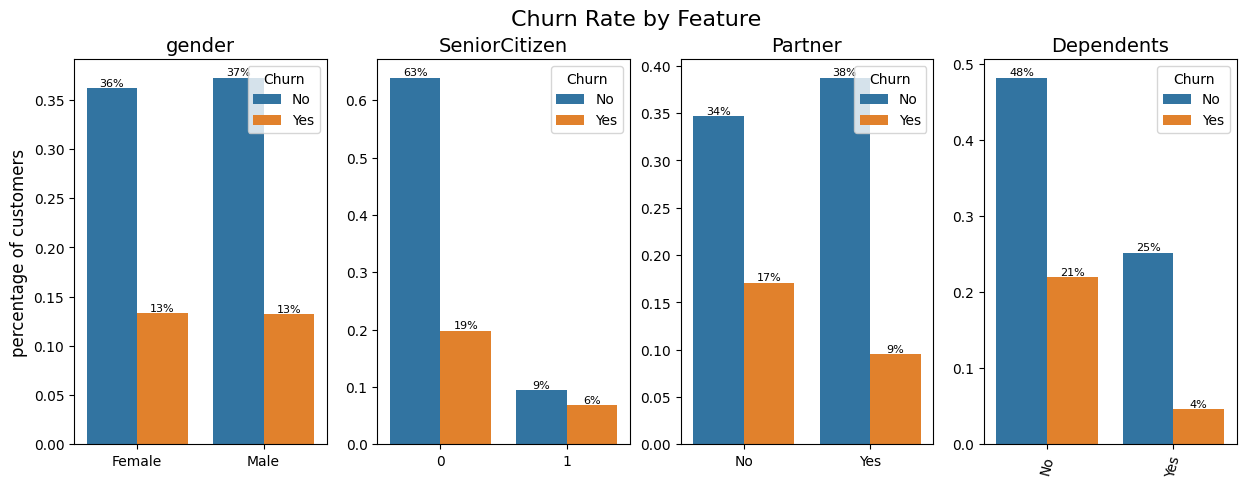

In [ ]:
def plot_churn_by_feature1D(df, features):
    size = len(features)
    fig, axes = plt.subplots(1, size , figsize=(15, 5))
    axis_y = "percentage of customers"

    for i, feature in enumerate(features):
        df_subset = df.groupby(feature)["Churn"].value_counts() / len(df)
        df_subset = df_subset.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
        sns.barplot(x=feature, y=axis_y, hue="Churn", data=df_subset, ax=axes[i])
        if i % size == 0:
            axes[i].set_ylabel(axis_y, fontsize=12)
        else:
            axes[i].set_ylabel("")

        # Set the title above the graph
        axes[i].set_title(feature, fontsize=14)
        axes[i].set_xlabel("")

        # Add the number of values in the bar
        for bar in axes[i].patches:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2, height, str(int(height * 100)) + "%", ha="center", va="bottom", size=8,wrap=True)

    plt.xticks(rotation = 75)
    plt.suptitle("Churn Rate by Feature", fontsize=16)
    plt.show()


features = ["gender", "SeniorCitizen", "Partner", "Dependents"]
plot_churn_by_feature1D(df, features)

From the above plot we can conclude:

*   Gender dosen't have any impact on the churn rate.
*   SeniorCitizen customers are a smaller cohort but they have higher churn rate.  
*   Churn rate is lower among customers with Partners.
*   Churn rate is lower among customers with Dependents.



In [ ]:
print(f"Total No. of customers {df.shape[0]}")
print(f"No. of customers with both PhoneService and InternetService {df[(df['PhoneService']=='Yes') & (df['InternetService']!='No')].shape[0]}")
print(f"No. of customers with neither PhoneService and InternetService {df[(df['PhoneService']=='No') & (df['InternetService']=='No')].shape[0]}")

Total No. of customers 7032
No. of customers with both PhoneService and InternetService 4832
No. of customers with neither PhoneService and InternetService 0


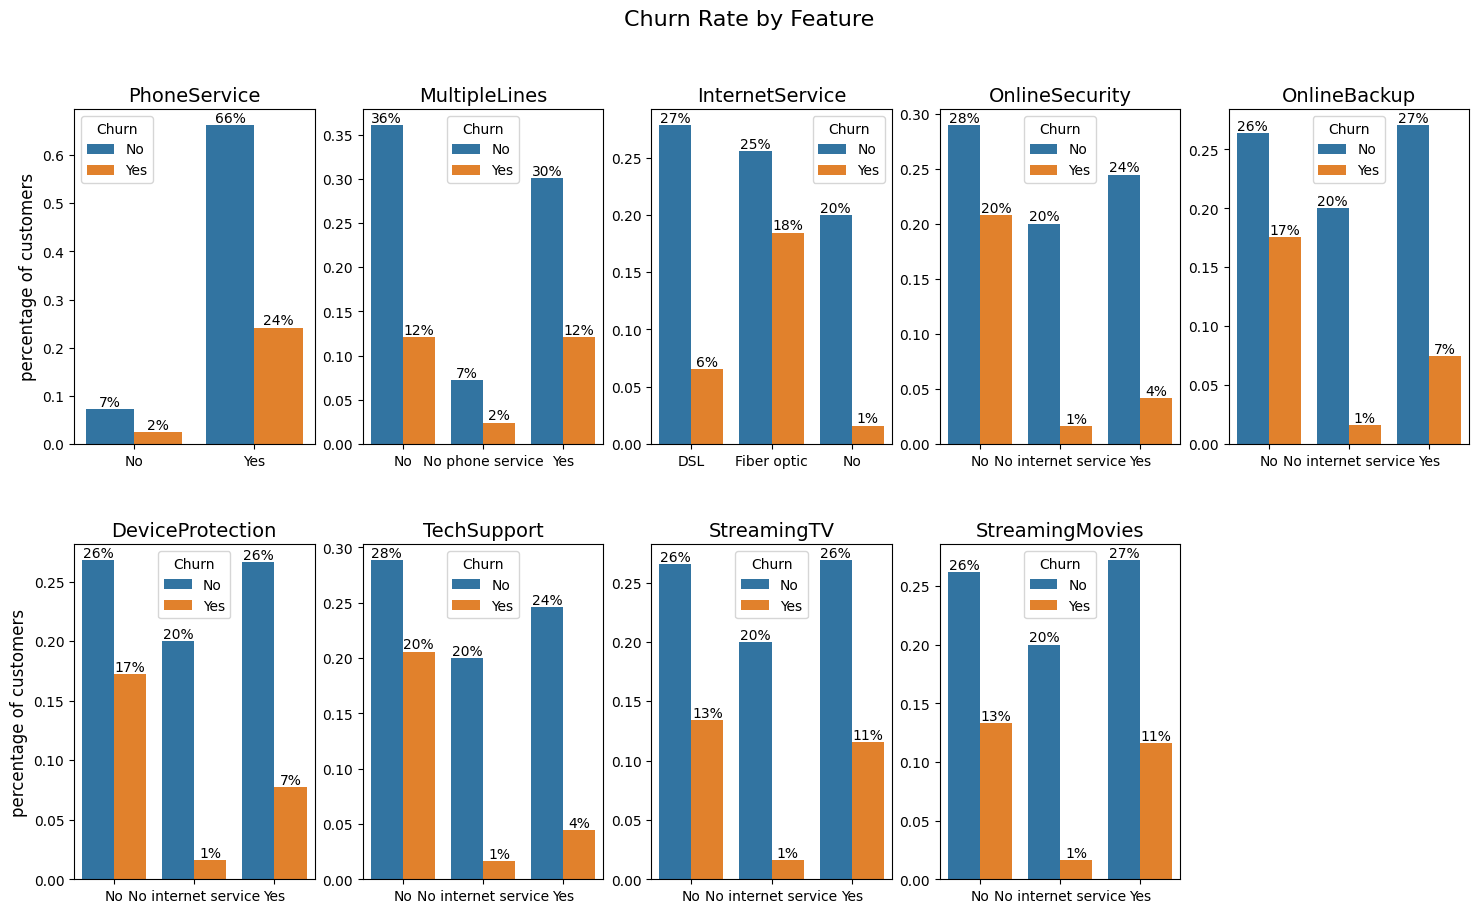

In [ ]:
def plot_churn_by_feature2D(df, features):

    fig, axes = plt.subplots(2, 5, figsize=(18, 10))
    axis_y = "percentage of customers"

    for i, feature in enumerate(features):
        df_subset = df.groupby(feature)["Churn"].value_counts() / len(df)
        df_subset = df_subset.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
        sns.barplot(x=feature, y=axis_y, hue="Churn", data=df_subset, ax=axes[i // 5, i % 5])
        if i % 5 == 0:
            axes[i // 5, i % 5].set_ylabel(axis_y, fontsize=12)
        else:
            axes[i // 5, i % 5].set_ylabel("")
        axes[1, 4].set_visible(False)
        # Set the title above the graph
        axes[i // 5, i % 5].set_title(feature, fontsize=14)
        axes[i // 5, i % 5].set_xlabel("")

        # Add the number of values in the bar
        for bar in axes[i // 5, i % 5].patches:
            height = bar.get_height()
            axes[i // 5, i % 5].text(bar.get_x() + bar.get_width()/2, height, str(int(height * 100)) + "%", ha="center", va="bottom")
    plt.subplots_adjust(hspace=0.3)
    plt.suptitle("Churn Rate by Feature", fontsize=16)
    plt.show()


features = ["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
plot_churn_by_feature2D(df, features)


From the above plot we can conclude:


*   Most of the users have PhoneService and the remaining 9% still have InternetService
*   Users with Multiple Phone Lines have a relatively higher churn rate
*   For InternetService Churn Rate follows the order FiberOptic>DSL>NoInternet, suggesting that users are churning more for advance tech, it could be a demand or service issue
*   Users with internet services such as OnlineSecurity, OnlineBackup,DeviceProtection, TechSupport have a very low churn rate as opposed to users without these services. Suggesting that users who have availed these services are more likely to stay with the company.
*   StreamingTV and StreamingMovies services don't seem to have much impact on the overall churn rate, since with users with or without these services have almost equal churn rate.






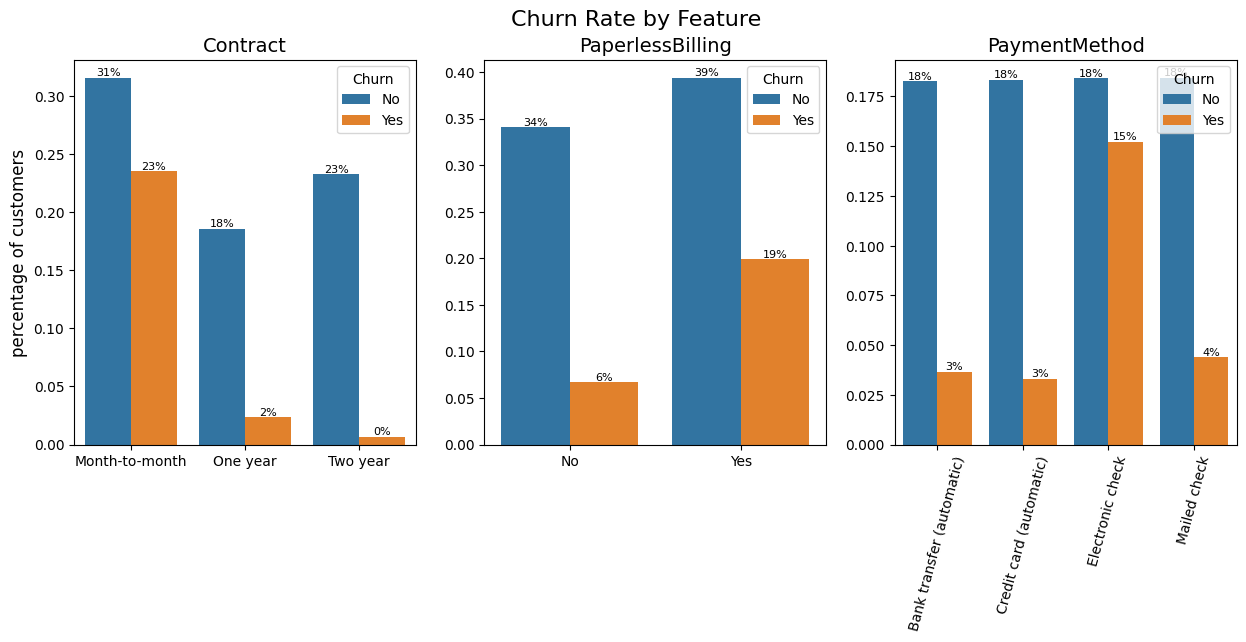

In [ ]:
features = ["Contract", "PaperlessBilling", "PaymentMethod"]
plot_churn_by_feature1D(df, features)

From the above plot we can conclude:


*   Month-to-Month Churn rate is very high, since a lot of users are usually taking trial of the services during the period.
*  Paperless Billing Churn rate is quite high, this could likely be due to some breakge in the payment gateway.
*   A staggering number of users who had used electronic check had churned, this is most likely due to a bad user experince while paying through this method.





**Feature Engineering**

In [ ]:
X = df.drop(columns=['Churn'])
y = df['Churn']

In [ ]:
from sklearn import set_config
set_config(display='diagram')

trf1 = ColumnTransformer([
    ('scale',StandardScaler(),['MonthlyCharges',	'TotalCharges',	'tenure']  )
], remainder ='passthrough')
trf2 = ColumnTransformer([
    ('Power',PowerTransformer(),list(range(3)))
],remainder='passthrough')
trf3 = ColumnTransformer([
    ('enc', OneHotEncoder(sparse_output = False, drop ='first'), list(range(3,len(X_train.columns))) )
],remainder='passthrough')

pipe = Pipeline([
    ('trf1',trf1),
    ('trf2',trf2),
    ('trf3',trf3)
])


In [ ]:
pipe.fit(X)
df2 = pipe.transform(X)


le = LabelEncoder()
y2 = le.fit_transform(y)
y2 = le.transform(y)

In [ ]:
#applying smoteENN
#from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

sm = SMOTEENN()
#smote = SMOTE(sampling_strategy=1)
f1,t1 = sm.fit_resample(df2,y2)


In [ ]:
yc1 = pd.DataFrame(y2).value_counts()
yc2 = pd.DataFrame(t1).value_counts()
print(yc1)
print(yc2)

0    5163
1    1869
dtype: int64
1    3698
0    2826
dtype: int64


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(f1, t1, test_size = 0.20, random_state = 2)

Model Training, Evaluation and Selection

<ipython-input-125-3eddbcc5bd58>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = pd.DataFrame(tr.transformers_[0][1].get_feature_names_out()).append(['MonthlyCharges','TotalCharges', 'tenure'])


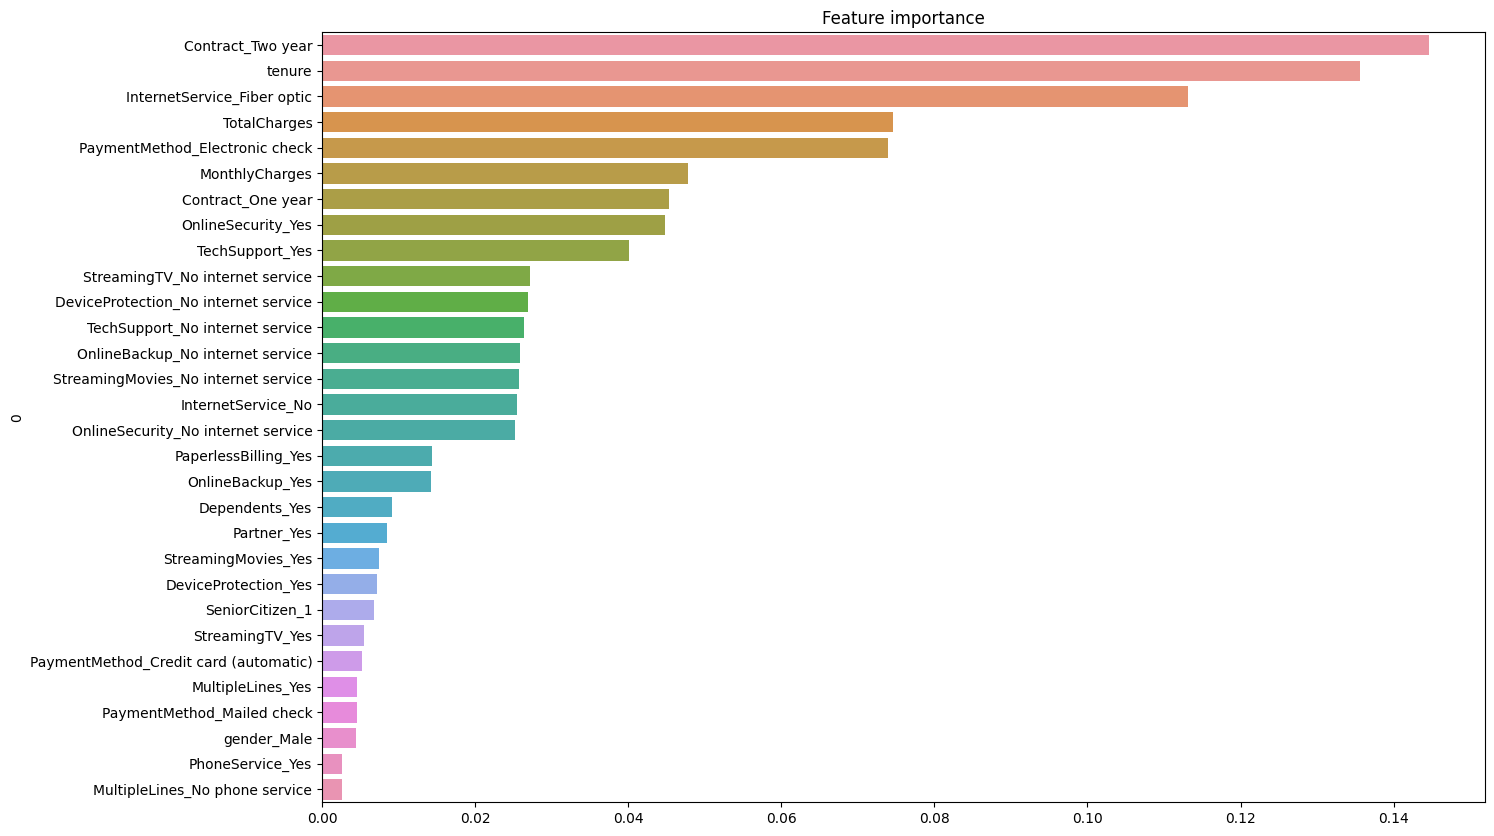

In [ ]:
#feature importance
from sklearn.ensemble import RandomForestClassifier

tr = ColumnTransformer([
    ('ohe',OneHotEncoder(sparse_output=False,drop='first'),['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'])
    ],remainder='passthrough')

fin = tr.fit(X)
x = pd.DataFrame(tr.transformers_[0][1].get_feature_names_out()).append(['MonthlyCharges','TotalCharges', 'tenure'])



clf = RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=5000, random_state=13)
clf = clf.fit(x_train, y_train)

fimp = pd.Series(data=clf.feature_importances_, index=x[:][0]).sort_values(ascending=False)
plt.figure(figsize=(15,10))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values,  orient='h')

In [ ]:
"""fimp = pd.Series(data=clf.feature_importances_, index=x[:][0]).sort_values(ascending=False)

X_train4 = pd.DataFrame(X_train3,columns=x[:][0])
X_train4.drop(columns = fimp[-7:].index.values,inplace=True)

X_test3 = pd.DataFrame(X_test2,columns=x[:][0])
X_test3.drop(columns = fimp[-7:].index.values,inplace=True)

X_test3 = X_test3.astype(float)"""

'fimp = pd.Series(data=clf.feature_importances_, index=x[:][0]).sort_values(ascending=False)\n\nX_train4 = pd.DataFrame(X_train3,columns=x[:][0])\nX_train4.drop(columns = fimp[-7:].index.values,inplace=True)\n\nX_test3 = pd.DataFrame(X_test2,columns=x[:][0])\nX_test3.drop(columns = fimp[-7:].index.values,inplace=True)\n\nX_test3 = X_test3.astype(float)'

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, classification_report,confusion_matrix,accuracy_score,recall_score,precision_score,f1_score

metrics = pd.DataFrame(columns=['Model','acc', 'recall', 'precision', 'f1','auc'])
def model(classifier,x_train,y_train,x_test,y_test):
  classifier.fit(x_train,y_train)
  y_pred = classifier.predict(x_test)

  cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)
  cv_train_acc = cross_val_score(classifier,x_train,y_train,cv=cv,scoring='accuracy')


  acc = accuracy_score(y_test,y_pred)
  recall = recall_score(y_test,y_pred)
  prec = precision_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  auc = roc_auc_score(y_test,y_pred)
  metrics.loc[len(metrics)] = [str(classifier), acc, recall, prec, f1, auc]

  print(f'Model CV accuracy - {round(cv_train_acc.mean(),2)}')
  cm = confusion_matrix(y_test,y_pred)
  cr = classification_report(y_test,y_pred)
  print(cr)

  names = ['True Neg','False Pos','False Neg','True Pos']
  counts = [value for value in cm.flatten()]
  percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')

Model CV accuracy - 0.91
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       591
           1       0.91      0.92      0.91       714

    accuracy                           0.90      1305
   macro avg       0.90      0.90      0.90      1305
weighted avg       0.90      0.90      0.90      1305



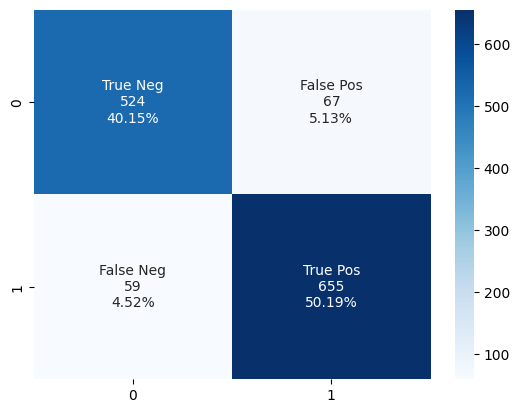

In [ ]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(solver='lbfgs',max_iter=1000),x_train,y_train, x_test , y_test)

Model CV accuracy - 0.92
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       591
           1       0.89      0.95      0.92       714

    accuracy                           0.91      1305
   macro avg       0.91      0.91      0.91      1305
weighted avg       0.91      0.91      0.91      1305



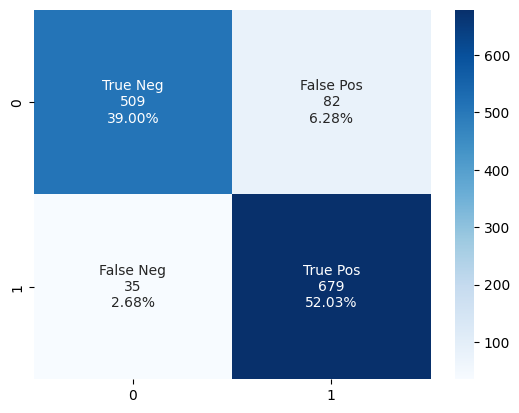

In [ ]:
#Random Forrest
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(max_depth = 4,random_state = 0),x_train,y_train, x_test , y_test)

Model CV accuracy - 0.93
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       591
           1       0.91      0.94      0.92       714

    accuracy                           0.91      1305
   macro avg       0.91      0.91      0.91      1305
weighted avg       0.91      0.91      0.91      1305



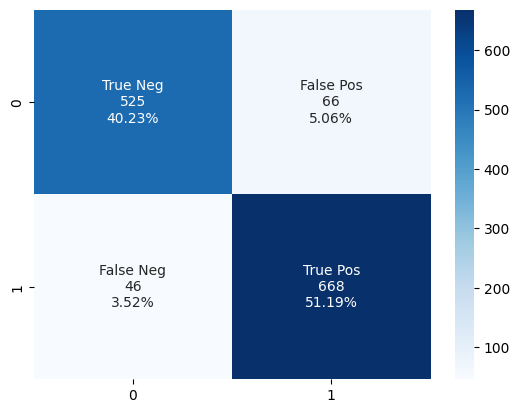

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

model(AdaBoostClassifier(n_estimators=200, learning_rate=0.2, algorithm='SAMME.R'),x_train,y_train, x_test , y_test)

Model CV accuracy - 0.91
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       591
           1       0.91      0.92      0.91       714

    accuracy                           0.90      1305
   macro avg       0.90      0.90      0.90      1305
weighted avg       0.90      0.90      0.90      1305



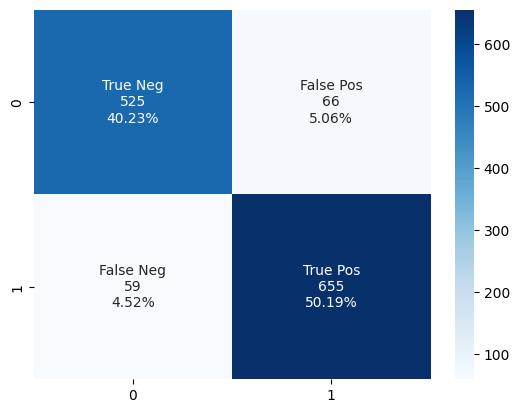

In [ ]:
from sklearn.svm import SVC

model(SVC(kernel='linear') ,x_train,y_train, x_test , y_test)

Model CV accuracy - 0.95
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       591
           1       0.94      0.96      0.95       714

    accuracy                           0.94      1305
   macro avg       0.94      0.94      0.94      1305
weighted avg       0.94      0.94      0.94      1305



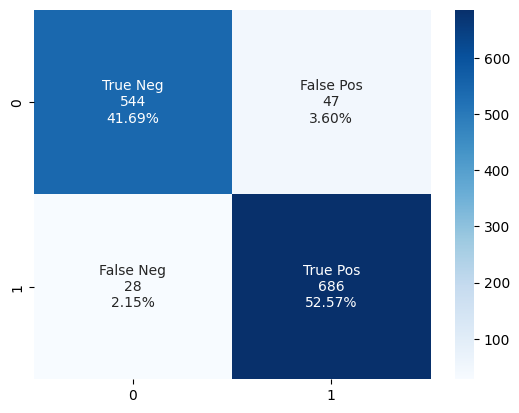

In [ ]:
from xgboost import XGBClassifier

model(XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000),x_train,y_train, x_test , y_test )

In [ ]:
NN = Sequential([
    Dense(40, activation="relu", input_shape=(x_train.shape[1],)),
    Dropout(0.3),
    Dense(20, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

# Compile the model
NN.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
NN.fit(x_train, y_train, epochs=15)

# Evaluate the model

yp = NN.predict(x_test)

Epoch 1/15
164/164 [==============================] - 1s 2ms/step - loss: 0.3802 - accuracy: 0.8366
Epoch 2/15
164/164 [==============================] - 0s 2ms/step - loss: 0.2574 - accuracy: 0.8992
Epoch 3/15
164/164 [==============================] - 0s 2ms/step - loss: 0.2498 - accuracy: 0.8984
Epoch 4/15
164/164 [==============================] - 0s 2ms/step - loss: 0.2390 - accuracy: 0.9059
Epoch 5/15
164/164 [==============================] - 0s 2ms/step - loss: 0.2307 - accuracy: 0.9094
Epoch 6/15
164/164 [==============================] - 0s 2ms/step - loss: 0.2253 - accuracy: 0.9113
Epoch 7/15
164/164 [==============================] - 0s 2ms/step - loss: 0.2240 - accuracy: 0.9124
Epoch 8/15
164/164 [==============================] - 0s 2ms/step - loss: 0.2205 - accuracy: 0.9136
Epoch 9/15
164/164 [==============================] - 0s 2ms/step - loss: 0.2167 - accuracy: 0.9130
Epoch 10/15
164/164 [==============================] - 0s 2ms/step - loss: 0.2128 - accuracy: 0.9188

In [ ]:
y_pred = []
for element in yp:
  if element > 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       591
           1       0.93      0.91      0.92       714

    accuracy                           0.91      1305
   macro avg       0.91      0.91      0.91      1305
weighted avg       0.91      0.91      0.91      1305



<Axes: >

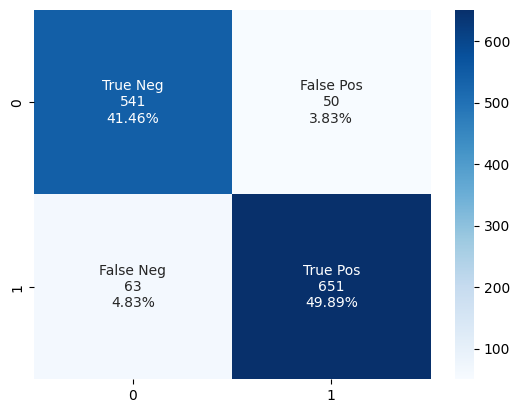

In [ ]:

cm = confusion_matrix(y_test,y_pred)
cr = classification_report(y_test,y_pred)
print(cr)

names = ['True Neg','False Pos','False Neg','True Pos']
counts = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')

In [ ]:
metrics

,Model,acc,recall,precision,f1,auc
0,LogisticRegression(max_iter=1000),0.903448,0.917367,0.907202,0.912256,0.902000
1,"RandomForestClassifier(max_depth=4, random_sta...",0.910345,0.950980,0.892247,0.920678,0.906116
2,"AdaBoostClassifier(learning_rate=0.2, n_estima...",0.914176,0.935574,0.910082,0.922652,0.911950
3,SVC(kernel='linear'),0.904215,0.917367,0.908460,0.912892,0.902846
4,"XGBClassifier(base_score=None, booster=None, c...",0.942529,0.960784,0.935880,0.948169,0.940629


In [ ]:
acc = accuracy_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred)
metrics.loc[len(metrics)] = ['NN', acc, recall, prec, f1, auc]


Clearly

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "n_estimators"  : [100,150,200,250],
    "learning_rate" : [ 0.20,0.25, 0.30, 0.34],
    "max_depth"     : [ 11, 12,13],
    "min_child_weight": [ 1,2, 3,4],
    "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7]
}

random_search = RandomizedSearchCV(XGBClassifier(),param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [ ]:
from datetime import datetime
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train4,y_train3)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Time taken: 0 hours 0 minutes and 52.64 seconds.


In [ ]:
random_search.best_params_

{'n_estimators': 200,
 'min_child_weight': 1,
 'max_depth': 12,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'colsample_bytree': 0.4}

Model CV accuracy - 0.96
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       591
           1       0.97      0.97      0.97       714

    accuracy                           0.97      1305
   macro avg       0.97      0.96      0.97      1305
weighted avg       0.97      0.97      0.97      1305



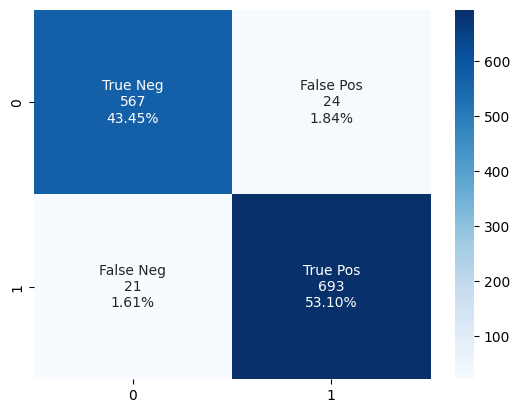

In [ ]:
model(XGBClassifier(n_estimators = 200,
  min_child_weight = 1,
  max_depth = 12,
  learning_rate = 0.2,
  gamma = 0.0,
  colsample_bytree = 0.4),x_train,y_train, x_test , y_test)

In [ ]:
metrics

,Model,acc,recall,precision,f1,auc
0,LogisticRegression(max_iter=1000),0.910078,0.930000,0.906685,0.918195,0.908220
1,"RandomForestClassifier(max_depth=4, random_sta...",0.905426,0.960000,0.877285,0.916780,0.900339
2,"AdaBoostClassifier(learning_rate=0.2, n_estima...",0.931783,0.952857,0.923823,0.938115,0.929818
3,SVC(kernel='linear'),0.907752,0.924286,0.907433,0.915782,0.906211
4,"XGBClassifier(base_score=None, booster=None, c...",0.949612,0.977143,0.933151,0.954641,0.947046
5,NN,0.926357,0.945714,0.920723,0.933051,0.924552
6,"XGBClassifier(base_score=None, booster=None, c...",0.965116,0.977143,0.959327,0.968153,0.963995


Since XGBoost model has the highest metrics, it has been selected for deployment

**Model Deployment**

In [ ]:
clf = XGBClassifier(n_estimators = 200,
  min_child_weight = 1,
  max_depth = 12,
  learning_rate = 0.2,
  gamma = 0.0,
  colsample_bytree = 0.4).fit(x_train,y_train)

In [ ]:
pipe.steps.append(("clf", clf))
pipe

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'tenure'])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Power', PowerTransformer(),
                                                  [0, 1, 2])])),
                ('trf3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enc',
                                                  OneHotEncoder(drop='fi...
                               feature_types=None, gamma=0.0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=12, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [ ]:
# export
import pickle
file_object = open("pipeline.pkl", "wb")
pickle.dump(pipe,file_object)
file_object.close()

In [ ]:
loaded_pipe = pickle.load(open("pipeline.pkl", "rb"))

In [ ]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'tenure', 'Churn'],
      dtype='object')

In [ ]:
ex1 =pd.DataFrame([['Male', 0, 'Yes', 'Yes', 'Yes',
                    'No', 'DSL', 'Yes', 'Yes',
                    'Yes','No', 'Yes', 'No',
                    'One year', 'No', 'Mailed check', 56.95,
                    1889.5, 34]],columns=df.columns[:-1])

ex2 = pd.DataFrame([['Male', 1, 'No', 'No', 'No',
                    'No', 'DSL', 'No', 'No',
                    'No','No', 'Yes', 'Yes',
                    'Month-to-month', 'No', 'Mailed check', 29.85,
                    108.15, 2]],columns=df.columns[:-1])

In [ ]:
prob_churn = loaded_pipe.predict_proba(ex2)[0][1]
prob_churn

0.99757034